In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Load training and test data into dataframes
data_train = pd.read_csv('/content/drive/My Drive/fashion-mnist_train.csv')
data_test = pd.read_csv('/content/drive/My Drive/fashion-mnist_test.csv')

# X forms the training images, and y forms the training labels
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# X_test forms the test images, and y_test forms the test labels
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

Using TensorFlow backend.


In [2]:
# Convert the training and test images into 3 channels
X = np.dstack([X] * 3)
X_test = np.dstack([X_test] * 3)

# Display their new shapes
X.shape, X_test.shape

((60000, 784, 3), (10000, 784, 3))

In [3]:
# Reshape images as per the tensor format required by tensorflow
X = X.reshape(-1, 28,28,3)
X_test= X_test.reshape (-1,28,28,3)

# Display the new shape
X.shape, X_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [0]:
# Resize the images as 150 * 150 as required by VGG19
from keras.preprocessing.image import img_to_array, array_to_img

X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])


In [0]:
# Normalise the data and change data type
X = X.astype('float32')
X /= 255

X_test = X_test.astype('float32')
X_test /= 255

In [6]:
from sklearn.model_selection import train_test_split

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [0]:
from keras.applications import VGG19

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (48, 48, 3), classes = 10)

In [8]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [0]:
from keras.applications.vgg19 import preprocess_input

# Preprocessing the input 
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [10]:
# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(X_test), batch_size=256, verbose=1)
val_features = vgg19.predict(np.array(X_val), batch_size=256, verbose=1)

12000/12000 [==============================] - 5s 399us/step


In [0]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_val)

In [12]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [0]:
# Flatten extracted features
train_features = np.reshape(train_features, (48000, 1*1*512))
test_features = np.reshape(test_features, (10000, 1*1*512))
val_features = np.reshape(val_features, (12000, 1*1*512))

In [0]:
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

In [0]:
import keras

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_features, y_train,
          batch_size=256,
          epochs=200,
          verbose=1,
          validation_data=(val_features, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 1s 18us/step - loss: 0.9573 - accuracy: 0.6559 - val_loss: 0.8553 - val_accuracy: 0.6937
Epoch 2/200
48000/48000 [==============================] - 1s 16us/step - loss: 0.9619 - accuracy: 0.6543 - val_loss: 0.8553 - val_accuracy: 0.6892
Epoch 3/200
48000/48000 [==============================] - 1s 15us/step - loss: 0.9599 - accuracy: 0.6547 - val_loss: 0.8405 - val_accuracy: 0.7044
Epoch 4/200
48000/48000 [==============================] - 1s 15us/step - loss: 0.9617 - accuracy: 0.6557 - val_loss: 0.8625 - val_accuracy: 0.6858
Epoch 5/200
48000/48000 [==============================] - 1s 15us/step - loss: 0.9616 - accuracy: 0.6564 - val_loss: 0.8588 - val_accuracy: 0.6966
Epoch 6/200
48000/48000 [==============================] - 1s 17us/step - loss: 0.9566 - accuracy: 0.6567 - val_loss: 0.8273 - val_accuracy: 0.7089
Epoch 7/200
48000/48000 [==============================] - 1s 

In [23]:

score = model.evaluate(test_features, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Test loss: 0.7761267954826355
Test accuracy: 73.35000038146973


Text(0.5, 1.0, 'Accuracy evolution')

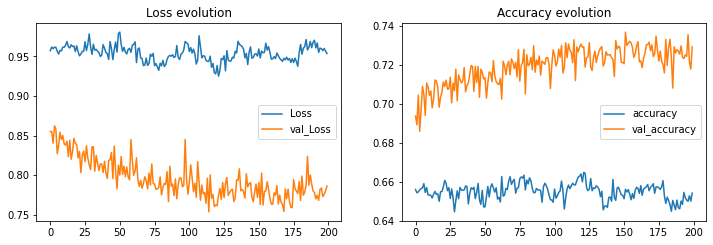

In [24]:
#VIsualizing the training performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy evolution')

In [0]:
predicted_classes = model.predict_classes(test_features)

In [42]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.63      0.70      0.66      1000
     Class 1       0.94      0.92      0.93      1000
     Class 2       0.57      0.59      0.58      1000
     Class 3       0.64      0.84      0.73      1000
     Class 4       0.61      0.59      0.60      1000
     Class 5       0.91      0.84      0.88      1000
     Class 6       0.44      0.31      0.36      1000
     Class 7       0.82      0.84      0.83      1000
     Class 8       0.90      0.82      0.86      1000
     Class 9       0.84      0.89      0.86      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

